# 1. Startup Application and Internal Memory 

In [3]:
import pickle
import pandas as pd
import hopsworks
import os

from keys import TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3
from TomTomAPI import get_traffic_map, plot_traffic_map, get_grid_from_map, get_traffic_map_from_grid, get_grid_from_map_alt
from HolidaysnWeather import get_weather, is_holiday

In [4]:
coordinates = 59.34318, 18.05141 # Stockholm near Odenplan
radius = 1000
zoom = 20

TOMTOM_keys = [TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3]

### 1.1. Create GRID for extracting traffic data

In [5]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map = get_traffic_map(TOMTOM_keys[i], coordinates, radius, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

Failed with key: 0
Failed with key: 1
eliminated: 7
eliminated: 3
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
eliminated: 2
eliminated: 2
eliminated: 1
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too 

1145
298


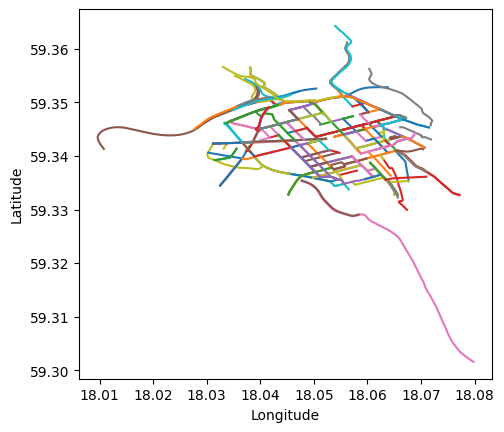

In [6]:
print(len(traffic_map))
traffic_map = set([str(s) for s in traffic_map])
traffic_map = [eval(s) for s in list(traffic_map)]
print(len(traffic_map))

plot_traffic_map(traffic_map)

In [7]:
grid = get_grid_from_map_alt(traffic_map)

with open('variables/grid.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(grid, file)

### 1.2. Collect traffic data

Failed with key: 0
Failed with key: 1
num of requests: 298
298
181


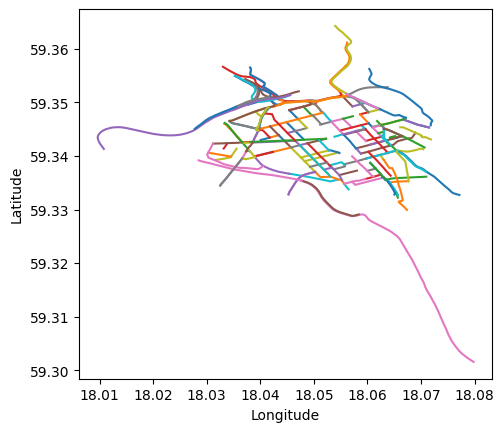

In [9]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map2 = get_traffic_map_from_grid(TOMTOM_keys[i],grid, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

print(len(traffic_map2))
traffic_map2 = set([str(s) for s in traffic_map2])
traffic_map2 = [eval(s) for s in list(traffic_map2)]
print(len(traffic_map2))

plot_traffic_map(traffic_map2, name = 'figures/traffic_map2.png')

In [10]:
from shapely.geometry import LineString
import datetime

traffic_df = pd.DataFrame(traffic_map)
traffic_df['coordinates'] = traffic_df['coordinates'].apply(lambda x: LineString([(point['longitude'], point['latitude']) for point in x['coordinate']]))
traffic_df = traffic_df.drop_duplicates()

today = datetime.datetime.now()
dates = [today for i in range(traffic_df.shape[0])]
multi_index = pd.MultiIndex.from_arrays(
    [dates,traffic_df['frc'], traffic_df['coordinates']],  # Pass as a list of arrays
    names=['date','frc', 'coordinates']  # Assign level names
)
traffic_df.index = multi_index

traffic_df = traffic_df.drop(columns = ['@version','frc', 'coordinates'])

print(traffic_df.shape)
traffic_df.head(1)

(298, 6)


,,,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence,roadClosure
date,frc,coordinates,,,,,,
2024-12-17 17:59:24.232795,FRC6,"LINESTRING (18.05793996855101 59.34143098065234, 18.05909868284573 59.341724696125944, 18.059121481622356 59.34173003871513, 18.05925425096865 59.34176491511634, 18.05930655404444 59.34177431806154, 18.05943664118169 59.34180919441731, 18.060249350513402 59.34203046183523, 18.06045856281662 59.342088118493734, 18.06070532604602 59.34215650283951, 18.061634711469907 59.34241802895159, 18.06197669311939 59.34251325319043, 18.06213896676485 59.342554838916534, 18.062234185184877 59.342578986822524, 18.063048235621096 59.34278550414185, 18.06316088839975 59.34281499430229, 18.06333389088124 59.342859272234236, 18.063544444288965 59.34290081479742, 18.06366246148562 59.342928979942506, 18.06379388972738 59.342962530198676, 18.063952140059314 59.34300411537467, 18.064051381792893 59.343032280434116, 18.064154646839967 59.34306177038026, 18.06434642478456 59.3431127152704, 18.064406774487452 59.34312882785816, 18.06448053523536 59.34314626534505, 18.06474070950989 59.34321195501312, 18.064911029782365 59.34325623242748, 18.065395168509667 59.34340107387494, 18.065447471585458 59.3434158186911, 18.065676800456288 59.34347885805031, 18.065931610312788 59.34354591470465, 18.066151551452037 59.34360895382239, 18.066308460679437 59.34365049546854, 18.066489509788 59.34369878970523)",14,20,140,98,0.92,False


### 1.3. Collect weather data

In [11]:
weather_df = get_weather(coordinates)
weather_df

,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2024-12-17,3.876,-0.274,0.0,33.48,279.474274


### 1.4. Collect weather data

In [12]:
holiday_status = is_holiday()
weather_df['holiday_status'] = holiday_status
weather_df

,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,holiday_status
2024-12-17,3.876,-0.274,0.0,33.48,279.474274,0


### 1.5. Joining data and uploading to Hopsworks

In [14]:
# Get the API key from GitHub Secrets
# HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')
with open('hopsworks-api-key.txt','r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

# Get AQI API KEY from secrets of hopsworks
project = hopsworks.login(project="ID2223LAB1KTH")

2024-12-17 17:59:57,676 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-17 17:59:57,680 INFO: Initializing external client
2024-12-17 17:59:57,682 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-17 17:59:58,943 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583


In [15]:

# Initialize the feature store

fs = project.get_feature_store()

# Define and insert the Air Quality Feature Group
traffic_fg = fs.get_or_create_feature_group(
    name="stockholm_traffic",
    version=1,
    description="Traffic data of odenplan : coordinates currentSpeed	freeFlowSpeed	currentTravelTime	freeFlowTravelTime	confidence	roadClosure",
    primary_key=["date"],  
    event_time="date" 
)

traffic_fg.insert(traffic_df)

# Define and insert the Air Quality Feature Group
weather_fg = fs.get_or_create_feature_group(
    name="stockholm_weather&holiday",
    version=1,
    description="Weather data for Stockholm including temperature, precipitation, wind speed and holiday",
    primary_key=["date"],  
    event_time="date" 
)

weather_fg.insert(weather_df)

2024-12-17 18:00:03,506 WARNING: FeatureGroupWarning: The ingested dataframe contains upper case letters in feature names: `['currentSpeed', 'freeFlowSpeed', 'currentTravelTime', 'freeFlowTravelTime', 'roadClosure']`. Feature names are sanitized to lower case in the feature store.



FeatureStoreException: Provided primary key(s) date doesn't exist in feature dataframe